# VARIATIONAL AUTOENCODER FOR HARMONIC SOUND GENERATION 

In this Jupyter notebook, you can find the code used for generating harmonic sounds using a variational autoencoder and exploring the latent space. The final part of the code is entirely focused on creating sound morphing from one sound to another.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea
from matplotlib.colors import ListedColormap
import matplotlib
import numpy as np
import pandas as pd
import os
import pickle

import librosa
import soundfile as sf
import sounddevice as sd
import noisereduce as nr

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils import data
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split
from tqdm import tqdm, tqdm_notebook
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Training on',DEVICE)

Training on cpu


In [2]:
sd._terminate()
sd._initialize()

In [3]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

## DATA PRE-PROCESSING

Pre-processing is crucial for data utilization in model training. It is a process that transforms audio clips into audio representations (specifically mel spectrograms), involving normalization and standardization operations.



In [5]:
def load_audio(file_path, sample_rate, duration, mono):
    signal = librosa.load(file_path, sr=sample_rate, duration=duration, mono=mono)[0]
    return signal

def apply_padding(array, num_missing_items, mode="constant"):
    if mode == "constant":
        padded_array = np.pad(array, (num_missing_items, 0), mode=mode)
    else:
        raise ValueError("Unsupported padding mode")
    return padded_array

def extract_mel_spectrogram(signal, sample_rate, frame_size, hop_length, n_mels):
    mel_spectrogram = librosa.feature.melspectrogram(
        y=signal, sr=sample_rate, n_fft=frame_size, hop_length=hop_length, n_mels=n_mels
    )
    return mel_spectrogram

def min_max_normalize(array, min_val, max_val):
    norm_array = (array - array.min()) / (array.max() - array.min())
    norm_array = norm_array * (max_val - min_val) + min_val
    return norm_array

def denormalize(norm_array, original_min, original_max, min_val, max_val):
    array = (norm_array - min_val) / (max_val - min_val)
    array = array * (original_max - original_min) + original_min
    return array

class MinMaxNormaliser:
    """MinMaxNormaliser applies min max normalisation to an array."""

    def __init__(self, min_val, max_val):
        self.min = min_val
        self.max = max_val

    def normalise(self, array):
        norm_array = (array - array.min()) / (array.max() - array.min())
        norm_array = norm_array * (self.max - self.min) + self.min
        return norm_array

    def denormalise(self, norm_array, original_min, original_max):
        array = (norm_array - self.min) / (self.max - self.min)
        array = array * (original_max - original_min) + original_min
        return array

def save_feature(feature, file_path, feature_save_dir):
    file_name = os.path.split(file_path)[1]
    save_path = os.path.join(feature_save_dir, file_name + ".npy")
    np.save(save_path, feature)
    return save_path

def save_min_max_values(min_max_values, min_max_values_save_dir):
    save_path = os.path.join(min_max_values_save_dir, "min_max_values.pkl")
    with open(save_path, "wb") as f:
        pickle.dump(min_max_values, f)

def process_audio_file(file_path, sample_rate, duration, mono, frame_size, hop_length, n_mels, min_val, max_val, feature_save_dir, min_max_values):
    signal = load_audio(file_path, sample_rate, duration, mono)
    num_expected_samples = int(sample_rate * duration)
    
    if len(signal) < num_expected_samples:
        signal = apply_padding(signal, num_expected_samples - len(signal))
    
    mel_spectrogram = extract_mel_spectrogram(signal, sample_rate, frame_size, hop_length, n_mels)
    norm_feature = min_max_normalize(mel_spectrogram, min_val, max_val)
    
    save_path = save_feature(norm_feature, file_path, feature_save_dir)
    
    min_max_values[save_path] = {
        "min": mel_spectrogram.min(),
        "max": mel_spectrogram.max()
    }

def preprocess_audio_directory(audio_files_dir, sample_rate, duration, mono, frame_size, hop_length, n_mels, min_val, max_val, feature_save_dir, min_max_values_save_dir):
    min_max_values = {}
    for root, _, files in os.walk(audio_files_dir):
        for file in files:
            file_path = os.path.join(root, file)
            process_audio_file(file_path, sample_rate, duration, mono, frame_size, hop_length, n_mels, min_val, max_val, feature_save_dir, min_max_values)
            print(f"Processed file {file_path}")
    
    save_min_max_values(min_max_values, min_max_values_save_dir)




In [11]:
def preprocess_audio_directory(audio_files_dir, sample_rate, duration, mono, frame_size, hop_length, n_mels, min_val, max_val, feature_save_dir, min_max_values_save_dir):
    min_max_values = {}
    for root, _, files in os.walk(audio_files_dir):
        for file in files:
            if not file.endswith(('.wav', '.mp3', '.flac', '.ogg', '.npy')) or file.startswith('.'):
                continue

            file_path = os.path.join(root, file)
            process_audio_file(file_path, sample_rate, duration, mono, frame_size, hop_length, n_mels, min_val, max_val, feature_save_dir, min_max_values)
            #print(f"Processed file {file_path}")
    
    save_min_max_values(min_max_values, min_max_values_save_dir)

    
def save_min_max_values(min_max_values, min_max_values_save_dir):
    save_path = os.path.join(min_max_values_save_dir, "min_max_values_h.pkl")
    with open(save_path, "wb") as f:
        pickle.dump(min_max_values, f)

In [34]:
%%capture
# Choose good parameters

FRAME_SIZE = 256*4
HOP_LENGTH = 256
DURATION = 5.94
SAMPLE_RATE = 22050
MONO = True
MIN_VAL = 0  
MAX_VAL = 1
N_MELS = 256#128

H_SPECTROGRAMS_SAVE_DIR = "/Users/chiaradeluca/Desktop/TESI + internship/all the sounds/spects"
H_MIN_MAX_VALUES_SAVE_DIR = "/Users/chiaradeluca/Desktop/TESI + internship/all the sounds/min_max"
H_FILES_DIR = "/Users/chiaradeluca/Desktop/TESI + internship/all the sounds"
H_MIN_MAX_VALUES_PATH = "/Users/chiaradeluca/Desktop/TESI + internship/all the sounds/min_max/min_max_values.pkl"

preprocess_audio_directory(H_FILES_DIR, SAMPLE_RATE, DURATION, MONO, FRAME_SIZE, HOP_LENGTH, N_MELS, MIN_VAL, MAX_VAL, H_SPECTROGRAMS_SAVE_DIR, H_MIN_MAX_VALUES_SAVE_DIR)


## DATA LOADING

The dataset consists of short audio clips, each containing the sustained and stable sound of a musical instrument. Musical timbres are categorized into three classes of instruments:

- Strings (violin, cello)
- Woodwind (flute, piccolo, clarinet, oboe)
- Brass (trumpet)

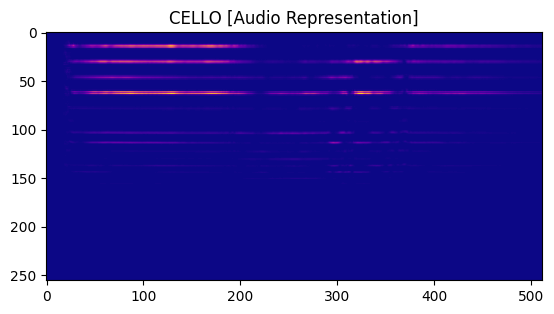

(256, 512)

In [63]:
mel_data = np.load('/Users/chiaradeluca/Desktop/TESI + internship/all the sounds/spects/cello_1223.wav.npy')
plt.imshow(mel_data, cmap = "plasma")
plt.title("CELLO [Audio Representation]")
plt.show()
mel_data.shape

In [64]:
def load_spectrograms_folder(folder_path):
    x_train = []
    y_train = []
    file_paths = []
    file_names = sorted(os.listdir(folder_path))

    for file_name in file_names:
        file_path = os.path.join(folder_path, file_name)

        if file_name.endswith('.npy'):
            spectrogram = np.load(file_path)
            x_train.append(spectrogram)
            file_paths.append(file_path)

            if file_name.startswith('clarinet'):
                y_train.append(0)
            elif file_name.startswith('oboe'):
                y_train.append(1)
            elif file_name.startswith('flute'):
                y_train.append(2)
            elif file_name.startswith('piccolo'):
                y_train.append(3)
            elif file_name.startswith('cello'):
                y_train.append(4)
            elif file_name.startswith('violin'):
                y_train.append(5)
            elif file_name.startswith('trumpet'):
                y_train.append(6)

    x_train = np.array(x_train)
    x_train = x_train[..., np.newaxis]
    x_train = np.transpose(x_train, (0, 3, 1, 2))

    y_train = np.array(y_train)
    return x_train, y_train#, file_paths


In [65]:
SPECTROGRAMS_PATH = "/Users/chiaradeluca/Desktop/TESI + internship/all the sounds/spects"

x_train, y_train = load_spectrograms_folder(SPECTROGRAMS_PATH)

In [66]:
instrument_dict = {
    "CLARINET": 0,
    "OBOE": 1,
    "FLUTE": 2,
    "PICCOLO": 3,
    "CELLO": 4,
    "VIOLIN": 5,
    "TRUMPET": 6
}

inv_instrument = {v: k for k, v in instrument_dict.items()}

print("Shapes:", x_train.shape, y_train.shape)
print("Labels:", inv_instrument)

Shapes: (2240, 1, 256, 512) (2240,)
Labels: {0: 'CLARINET', 1: 'OBOE', 2: 'FLUTE', 3: 'PICCOLO', 4: 'CELLO', 5: 'VIOLIN', 6: 'TRUMPET'}


In [67]:
#Data Shuffle

indices = np.arange(len(x_train))
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

In [19]:
batch_size = 64 

x_train_tensor = torch.tensor(x_train[:1800], dtype=torch.float32)
y_train_tensor = torch.tensor(y_train[:1800], dtype=torch.long)

train_dataset = torch.utils.data.TensorDataset(x_train_tensor[:1800], y_train_tensor[:1800])
train_loader1 = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

x_test_tensor = torch.tensor(x_train[1800:], dtype=torch.float32)
y_test_tensor = torch.tensor(y_train[1800:], dtype=torch.long)

test_dataset = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)
test_loader1 = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

train_dataset = train_loader1
val_dataset =test_loader1

print(y_train_tensor.shape, x_train_tensor.shape, y_test_tensor.shape, x_test_tensor.shape)

torch.Size([1800]) torch.Size([1800, 1, 256, 512]) torch.Size([440]) torch.Size([440, 1, 256, 512])


Text(0.5, 1.0, 'CELLO SOUND')

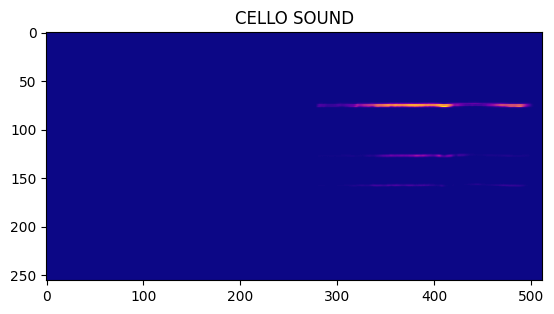

In [68]:
audio_index = 23

instrument = inv_instrument.get(np.int0(y_train_tensor[audio_index]))

plt.imshow(np.squeeze(x_train[audio_index]), cmap = "plasma")
plt.title(f"{instrument} SOUND")

In [69]:
sound_audio = librosa.feature.inverse.mel_to_audio(np.squeeze(x_train[audio_index]), hop_length=256, n_fft=1024)

sr = 22050 

sd.play(sound_audio, samplerate = sr)
sd.wait()

### Fade-in/Fade-out + Overlapping

Crossfading operations are preliminary and fundamental for merging sounds, especially for sound morphing.

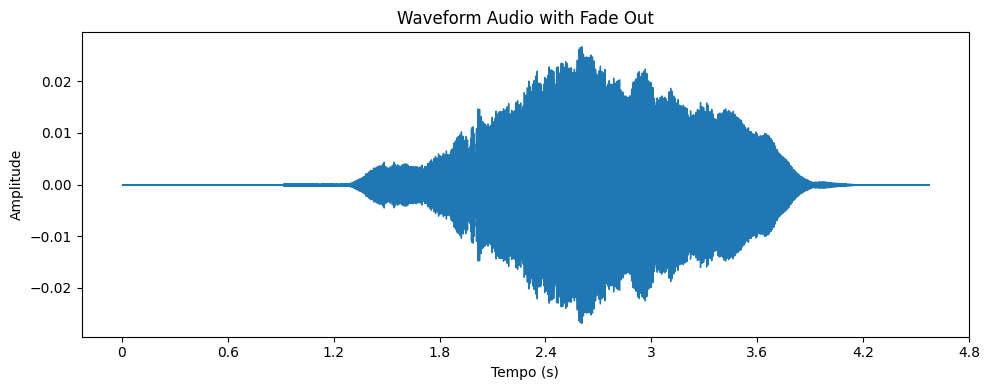

In [22]:
sound_audio = librosa.feature.inverse.mel_to_audio(np.squeeze(x_train[audio_index]), hop_length=256, n_fft=1024)[30000:]#1024)#2048)
sec = 2

def apply_log_fadeout(sound, fade_duration_samples):

    t = np.linspace(1, np.exp(1), fade_duration_samples)
    fade_out = np.log(t)

    fade_out = (fade_out - fade_out.min()) / (fade_out.max() - fade_out.min())
    fade_out = 1 - fade_out

    sound[-fade_duration_samples:] *= fade_out

    return sound


fade_duration_samples = sec*22050
suono_faded1 = apply_log_fadeout(sound_audio, fade_duration_samples)

plt.figure(figsize=(10, 4))
librosa.display.waveshow(suono_faded1, sr=sr)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Waveform Audio with Fade Out')
plt.tight_layout()
plt.show()

    # Riproduci l'audio risultante due volte di fila
sd.play(suono_faded1, sr)
sd.wait()

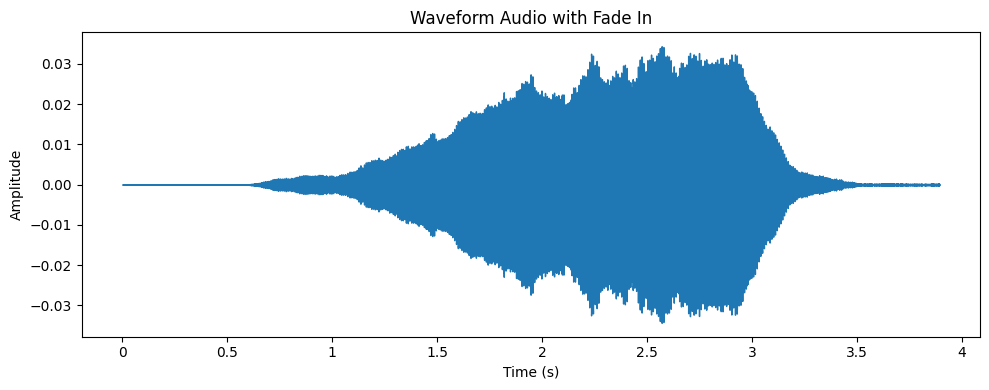

In [23]:
sound_audio = librosa.feature.inverse.mel_to_audio(np.squeeze(x_train[audio_index]), hop_length=256, n_fft=1024)[45000:]
sec = 2

def apply_log_fadein(sound, fade_duration_samples):

    t = np.linspace(1, np.exp(1), fade_duration_samples)
    fade_in = np.log(t)
    fade_in = (fade_in - fade_in.min()) / (fade_in.max() - fade_in.min())
    sound[:fade_duration_samples] *= fade_in
    return sound

fade_duration_samples = sec*22050
suono_faded2 = apply_log_fadein(sound_audio, fade_duration_samples)

plt.figure(figsize=(10, 4))
librosa.display.waveshow(suono_faded2, sr=sr)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform Audio with Fade In')
plt.tight_layout()
plt.show()

sd.play(suono_faded2, sr)
sd.wait()


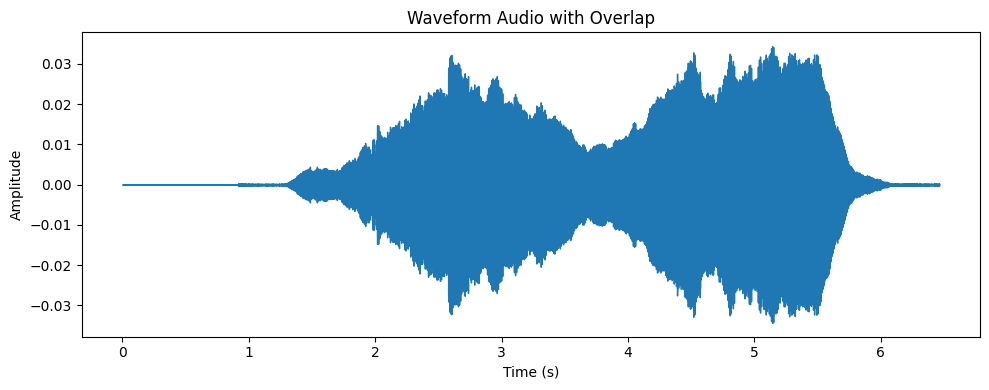

In [24]:
sec = 2

def overlap_sounds(sound1, sound2, sr):
    
    overlap_samples = sr * sec
    overlap1 = sound1[-overlap_samples:]
    overlap2 = sound2[:overlap_samples]
    average_overlap = (overlap1 + overlap2) * 1.2

    result = np.concatenate((sound1[:-overlap_samples], average_overlap, sound2[overlap_samples:]))

    return result

sound1 = suono_faded1  
sound2 = suono_faded2  

overlapped_sound = overlap_sounds(sound1, sound2, sr)

plt.figure(figsize=(10, 4))
librosa.display.waveshow(overlapped_sound, sr=sr)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform Audio with Overlap')
plt.tight_layout()
plt.show()

sd.play(overlapped_sound, sr)
sd.wait()


## Utility functions

The following functions will be used for visualizing the training progress, estimating the latent space, and reducing the dimensionality of the latent space in order to visualize it in a 2/3-dimensional space.

In [25]:
# Utility functions

def one_hot(x, max_x):
    return torch.eye(max_x + 1)[x]

def plot_gallery(images, h, w, n_row=3, n_col=6):
    plt.figure(figsize=(2 * n_col, 2 * n_row))
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.axis("off")
        plt.imshow(images[i].reshape(h, w), cmap = "plasma")
    plt.show()
    
def plot_loss(history):
    loss, val_loss = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    
def get_latent_data(net, count=1000, is_cvae=False):
    latent_vectors = []
    latent_labels = []
    img_inputs = []
    rounds = count/100
    i=0
    with torch.set_grad_enabled(False):
        dataset_loader = train_loader1
        for inputs,labels in dataset_loader:
            inputs = inputs.to(DEVICE)
            labels_one_hot = one_hot(labels,7).to(DEVICE)
            if is_cvae:
                outputs, mu, logvar = net(inputs,labels_one_hot)
            else:
                outputs = net(inputs,labels_one_hot)
            outputs = outputs.cpu()
            if i==0:
              latent_vectors = outputs
              latent_labels = labels
              img_inputs = inputs
            else:
              latent_vectors = torch.cat((latent_vectors,outputs),0)
              latent_labels = torch.cat((latent_labels,labels),0)
              img_inputs = torch.cat((img_inputs,inputs),0)
            if i>rounds:
              break
            i+=1
    return img_inputs, latent_vectors, latent_labels
    
def plot_pca(net, mode, count, is_cvae=False):
    img_inputs, latent_vectors, latent_labels = get_latent_data(net=net, count=count, is_cvae=is_cvae)
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_title('PCA')

    pca = PCA(n_components=2)
    coords = pca.fit_transform(latent_vectors)

    if mode == 'imgs':
        for image, (x, y) in zip(img_inputs.cpu(), coords):
            im = OffsetImage(image.reshape(256, 512), zoom=0.1, cmap='plasma')
            ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
            ax.add_artist(ab)
        ax.update_datalim(coords)
        ax.autoscale()
    elif mode == 'dots':
        classes = latent_labels
        num_classes = len(np.unique(classes))
        cmap = ListedColormap(plt.cm.autumn(np.linspace(0, 1, num_classes)))
        labels = [list(instrument_dict.keys())[i] for i in range(num_classes)]  

        plt.scatter(coords[:, 0], coords[:, 1], c=classes, cmap=cmap)
        plt.colorbar()
        for i in range(num_classes):
            class_center = np.mean(coords[classes == i], axis=0)
            text = TextArea('{}'.format(i))
            ax.annotate(labels[i], (class_center[0], class_center[1]))
            
        #plt.colorbar()
        plt.legend()
    plt.show()
    
def plot_pca_3d(net, count, is_cvae=False):
    img_inputs, latent_vectors, latent_labels = get_latent_data(net=net, count=count, is_cvae=is_cvae)
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d') 

    pca = PCA(n_components=3)
    coords = pca.fit_transform(latent_vectors)

    classes = latent_labels
    num_classes = len(np.unique(classes))
    cmap = ListedColormap(plt.cm.gist_rainbow(np.linspace(0, 1, num_classes)))

    for i in range(num_classes):
        class_coords = coords[classes == i]
        x = class_coords[:, 0]
        y = class_coords[:, 1]
        z = class_coords[:, 2]
        label = list(instrument_dict.keys())[i]
        #label = 'Sound {}'.format(i)
        ax.scatter(x, y, z, label=label, cmap=cmap)

    ax.set_title('PCA 3D (3 components)')
    ax.legend()
    plt.show()
       
def get_latent_data(net, count=1000, is_cvae=False):
    latent_vectors = []
    latent_labels = []
    img_inputs = []
    rounds = count/100
    i=0
    with torch.set_grad_enabled(False):
        dataset_loader = train_loader1
        for inputs,labels in dataset_loader:
            inputs = inputs.to(DEVICE)
            labels_one_hot = one_hot(labels,7).to(DEVICE)
            if is_cvae:
                outputs, mu, logvar = net(inputs,labels_one_hot)
            else:
                outputs = net(inputs,labels_one_hot)
            outputs = outputs.cpu()
            if i==0:
              latent_vectors = outputs
              latent_labels = labels
              img_inputs = inputs
            else:
              latent_vectors = torch.cat((latent_vectors,outputs),0)
              latent_labels = torch.cat((latent_labels,labels),0)
              img_inputs = torch.cat((img_inputs,inputs),0)
            if i>rounds:
              break
            i+=1
    return img_inputs, latent_vectors, latent_labels

def plot_tsne(net, mode, count, is_cvae=False):
    img_inputs, latent_vectors, latent_labels = get_latent_data(net=net, count=count, is_cvae=is_cvae)
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_title('t-SNE')
    coords = TSNE(n_components=2, random_state=42).fit_transform(latent_vectors)
    
    if mode == 'imgs':
        for image, (x, y) in zip(img_inputs.cpu(), coords):
            im = OffsetImage(image.reshape(256, 512), zoom=0.1, cmap='plasma')
            ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
            ax.add_artist(ab)
        ax.update_datalim(coords)
        ax.autoscale()
    elif mode == 'dots':
        classes = latent_labels
        num_classes = len(np.unique(classes))
        cmap = plt.cm.get_cmap('viridis', num_classes)  

        labels = [list(instrument_dict.keys())[i] for i in range(num_classes)]  

        for i in range(num_classes):
            class_coords = coords[classes == i]
            plt.scatter(class_coords[:, 0], class_coords[:, 1], label=labels[i], cmap=cmap)

        plt.colorbar()
        plt.legend()  
    plt.show()

# CVAE

In the following cells, the CVAE model will be implemented. Various attempts have been made by varying parameters and hyperparameters. The code will present one of the most efficient models in terms of generative and computational performance.

In [77]:
batch_size = 64#128
learning_rate = 0.0005
input_size = 256*512

hidden_size = 256-8 
num_epochs = 100
labels_length = 8 

In [78]:
class CVAE(nn.Module):
    def __init__(self, input_size, hidden_size=hidden_size):
        super(CVAE, self).__init__()
        input_size_with_label = input_size + labels_length
        hidden_size += labels_length
        
        self.fc1 = nn.Linear(input_size_with_label,512)
        self.fc21 = nn.Linear(512, hidden_size)
        self.fc22 = nn.Linear(512, hidden_size)
        
        self.relu = nn.ReLU()
        
        self.fc3 = nn.Linear(hidden_size, 512)
        self.fc4 = nn.Linear(512, input_size)
    
    def encode(self, x, labels):
        x = x.view(-1, input_size)
        x = torch.cat((x, labels), 1)
        x = self.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)
        
    def decode(self, z):
        z = self.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(z))
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 *logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
        
    def forward(self,x, labels):
        #targets = one_hot(targets,labels_length-1).float().to(DEVICE)
        mu, logvar = self.encode(x, labels)
        z = self.reparameterize(mu, logvar)
        x = self.decode(z)
        return x, mu, logvar

def train_cvae(net, dataloader, test_dataloader, flatten=True, epochs=num_epochs):
    validation_losses = []
    optim = torch.optim.Adam(net.parameters())

    log_template = "\nEpoch {ep:03d} val_loss {v_loss:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:  
        for i in range(epochs):
            for batch, labels in dataloader:
                batch = batch.to(DEVICE)
                labels = one_hot(labels,7).to(DEVICE)

                if flatten:
                    batch = batch.view(batch.size(0), input_size)

                optim.zero_grad()
                x,mu,logvar = net(batch, labels)
                loss = vae_loss_fn(batch, x[:, :input_size], mu, logvar)
                loss.backward()
                optim.step()
            evaluate(validation_losses, net, test_dataloader, flatten=True)
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=i+1, v_loss=validation_losses[i]))
    plt.show()
    return validation_losses

In [79]:
cvae = CVAE(input_size).to(DEVICE)

epoch:   0%|                                            | 0/100 [00:00<?, ?it/s]

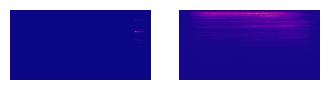

epoch:   1%|▎                                   | 1/100 [00:10<17:47, 10.78s/it]


Epoch 001 val_loss 0.0038


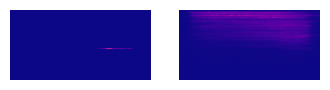

epoch:   2%|▋                                   | 2/100 [00:19<15:59,  9.79s/it]


Epoch 002 val_loss 0.0015


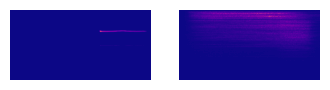

epoch:   3%|█                                   | 3/100 [00:28<15:18,  9.47s/it]


Epoch 003 val_loss 0.0015


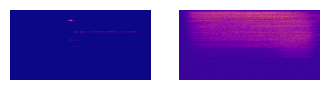

epoch:   4%|█▍                                  | 4/100 [00:38<15:15,  9.54s/it]


Epoch 004 val_loss 0.0014


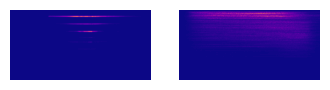

epoch:   5%|█▊                                  | 5/100 [00:47<14:56,  9.44s/it]


Epoch 005 val_loss 0.0014


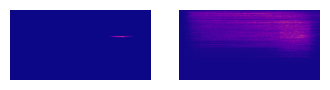

epoch:   6%|██▏                                 | 6/100 [00:57<14:48,  9.45s/it]


Epoch 006 val_loss 0.0013


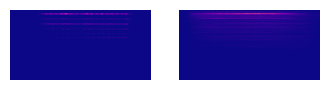

epoch:   7%|██▌                                 | 7/100 [01:06<14:18,  9.23s/it]


Epoch 007 val_loss 0.0013


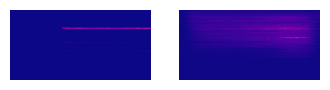

epoch:   8%|██▉                                 | 8/100 [01:14<13:40,  8.92s/it]


Epoch 008 val_loss 0.0012


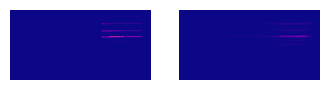

epoch:   9%|███▏                                | 9/100 [01:23<13:40,  9.02s/it]


Epoch 009 val_loss 0.0011


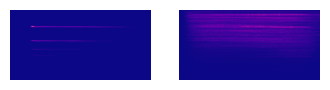

epoch:  10%|███▌                               | 10/100 [01:33<13:59,  9.33s/it]


Epoch 010 val_loss 0.0010


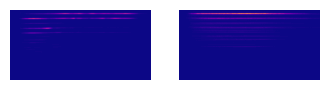

epoch:  11%|███▊                               | 11/100 [01:42<13:33,  9.15s/it]


Epoch 011 val_loss 0.0009


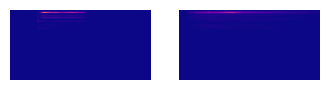

epoch:  12%|████▏                              | 12/100 [01:50<13:03,  8.91s/it]


Epoch 012 val_loss 0.0008


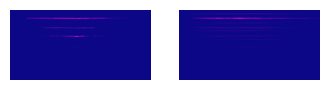

epoch:  13%|████▌                              | 13/100 [01:59<12:38,  8.72s/it]


Epoch 013 val_loss 0.0008


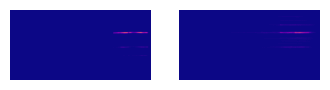

epoch:  14%|████▉                              | 14/100 [02:07<12:12,  8.52s/it]


Epoch 014 val_loss 0.0008


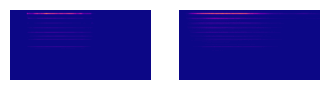

epoch:  15%|█████▎                             | 15/100 [02:14<11:45,  8.30s/it]


Epoch 015 val_loss 0.0007


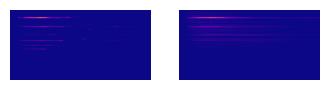

epoch:  16%|█████▌                             | 16/100 [02:23<11:38,  8.31s/it]


Epoch 016 val_loss 0.0007


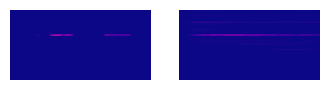

epoch:  17%|█████▉                             | 17/100 [02:31<11:26,  8.27s/it]


Epoch 017 val_loss 0.0007


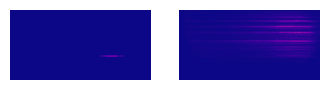

epoch:  18%|██████▎                            | 18/100 [02:39<11:09,  8.17s/it]


Epoch 018 val_loss 0.0007


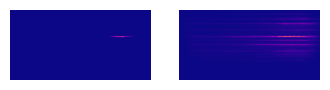

epoch:  19%|██████▋                            | 19/100 [02:49<11:43,  8.68s/it]


Epoch 019 val_loss 0.0007


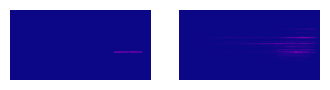

epoch:  20%|███████                            | 20/100 [02:58<11:49,  8.86s/it]


Epoch 020 val_loss 0.0006


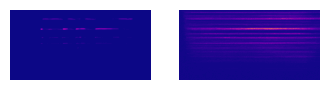

epoch:  21%|███████▎                           | 21/100 [03:07<11:41,  8.88s/it]


Epoch 021 val_loss 0.0006


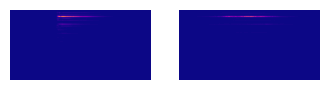

epoch:  22%|███████▋                           | 22/100 [03:16<11:27,  8.82s/it]


Epoch 022 val_loss 0.0006


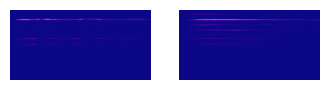

epoch:  23%|████████                           | 23/100 [03:25<11:23,  8.88s/it]


Epoch 023 val_loss 0.0006


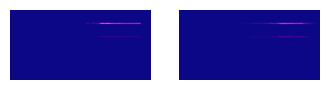

epoch:  24%|████████▍                          | 24/100 [03:35<11:49,  9.33s/it]


Epoch 024 val_loss 0.0006


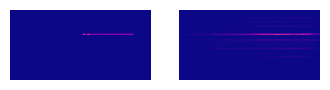

epoch:  25%|████████▊                          | 25/100 [03:45<11:51,  9.49s/it]


Epoch 025 val_loss 0.0006


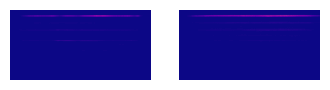

epoch:  26%|█████████                          | 26/100 [03:54<11:25,  9.26s/it]


Epoch 026 val_loss 0.0006


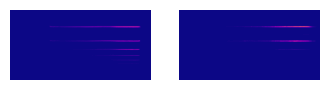

epoch:  27%|█████████▍                         | 27/100 [04:02<10:50,  8.92s/it]


Epoch 027 val_loss 0.0005


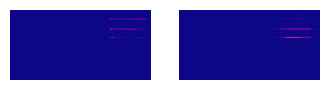

epoch:  28%|█████████▊                         | 28/100 [04:12<11:16,  9.39s/it]


Epoch 028 val_loss 0.0006


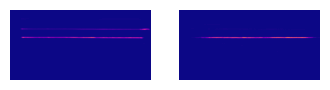

epoch:  29%|██████████▏                        | 29/100 [04:22<11:15,  9.52s/it]


Epoch 029 val_loss 0.0006


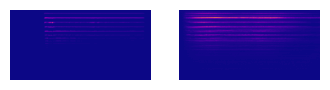

epoch:  30%|██████████▌                        | 30/100 [04:30<10:39,  9.13s/it]


Epoch 030 val_loss 0.0006


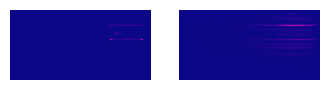

epoch:  31%|██████████▊                        | 31/100 [04:38<10:07,  8.80s/it]


Epoch 031 val_loss 0.0006


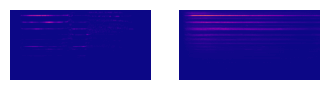

epoch:  32%|███████████▏                       | 32/100 [04:46<09:40,  8.54s/it]


Epoch 032 val_loss 0.0005


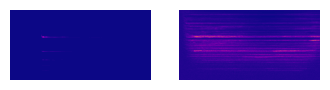

epoch:  33%|███████████▌                       | 33/100 [04:55<09:44,  8.72s/it]


Epoch 033 val_loss 0.0005


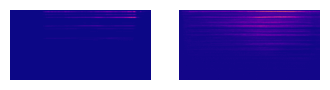

epoch:  34%|███████████▉                       | 34/100 [05:05<09:51,  8.97s/it]


Epoch 034 val_loss 0.0005


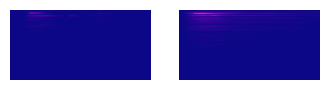

epoch:  35%|████████████▎                      | 35/100 [05:14<09:38,  8.90s/it]


Epoch 035 val_loss 0.0005


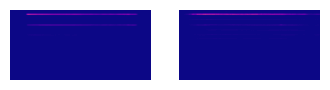

epoch:  36%|████████████▌                      | 36/100 [05:22<09:26,  8.86s/it]


Epoch 036 val_loss 0.0005


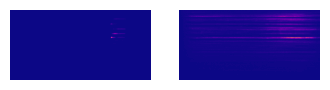

epoch:  37%|████████████▉                      | 37/100 [05:31<09:11,  8.75s/it]


Epoch 037 val_loss 0.0005


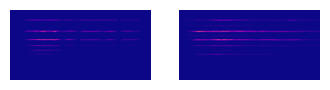

epoch:  38%|█████████████▎                     | 38/100 [05:39<08:57,  8.66s/it]


Epoch 038 val_loss 0.0005


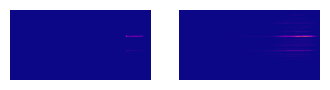

epoch:  39%|█████████████▋                     | 39/100 [05:48<08:50,  8.70s/it]


Epoch 039 val_loss 0.0005


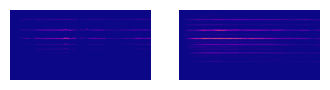

epoch:  40%|██████████████                     | 40/100 [05:57<08:38,  8.64s/it]


Epoch 040 val_loss 0.0005


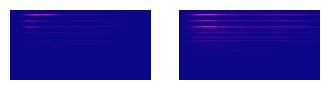

epoch:  41%|██████████████▎                    | 41/100 [06:06<08:43,  8.88s/it]


Epoch 041 val_loss 0.0005


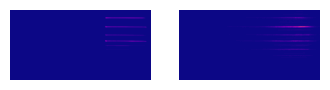

epoch:  42%|██████████████▋                    | 42/100 [06:15<08:44,  9.04s/it]


Epoch 042 val_loss 0.0005


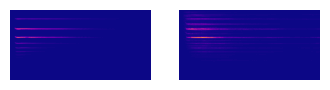

epoch:  43%|███████████████                    | 43/100 [06:24<08:23,  8.83s/it]


Epoch 043 val_loss 0.0005


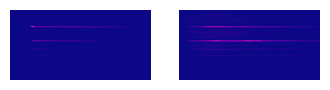

epoch:  44%|███████████████▍                   | 44/100 [06:34<08:38,  9.26s/it]


Epoch 044 val_loss 0.0005


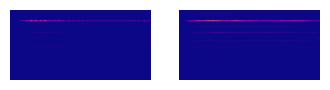

epoch:  45%|███████████████▊                   | 45/100 [06:45<08:49,  9.63s/it]


Epoch 045 val_loss 0.0005


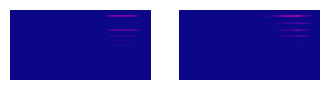

epoch:  46%|████████████████                   | 46/100 [06:53<08:27,  9.41s/it]


Epoch 046 val_loss 0.0005


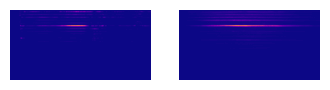

epoch:  47%|████████████████▍                  | 47/100 [07:02<08:01,  9.08s/it]


Epoch 047 val_loss 0.0005


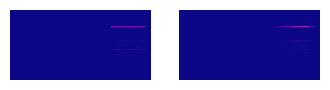

epoch:  48%|████████████████▊                  | 48/100 [07:10<07:33,  8.73s/it]


Epoch 048 val_loss 0.0005


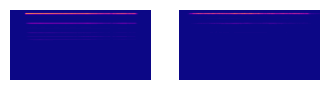

epoch:  49%|█████████████████▏                 | 49/100 [07:18<07:12,  8.47s/it]


Epoch 049 val_loss 0.0005


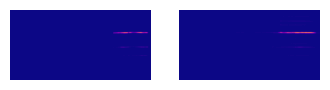

epoch:  50%|█████████████████▌                 | 50/100 [07:25<06:51,  8.24s/it]


Epoch 050 val_loss 0.0005


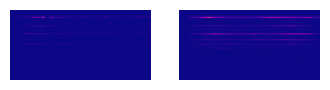

epoch:  51%|█████████████████▊                 | 51/100 [07:33<06:42,  8.22s/it]


Epoch 051 val_loss 0.0005


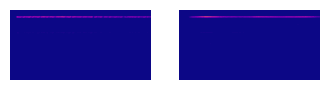

epoch:  52%|██████████████████▏                | 52/100 [07:41<06:29,  8.11s/it]


Epoch 052 val_loss 0.0005


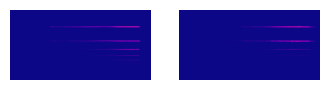

epoch:  53%|██████████████████▌                | 53/100 [07:51<06:40,  8.52s/it]


Epoch 053 val_loss 0.0005


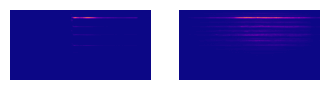

epoch:  54%|██████████████████▉                | 54/100 [07:59<06:25,  8.37s/it]


Epoch 054 val_loss 0.0005


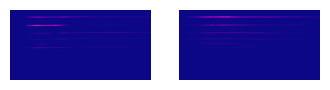

epoch:  55%|███████████████████▎               | 55/100 [08:07<06:09,  8.20s/it]


Epoch 055 val_loss 0.0005


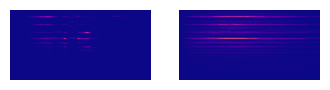

epoch:  56%|███████████████████▌               | 56/100 [08:14<05:56,  8.11s/it]


Epoch 056 val_loss 0.0005


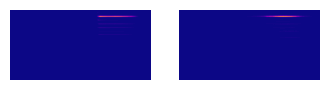

epoch:  57%|███████████████████▉               | 57/100 [08:22<05:47,  8.08s/it]


Epoch 057 val_loss 0.0005


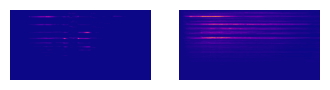

epoch:  58%|████████████████████▎              | 58/100 [08:32<05:55,  8.48s/it]


Epoch 058 val_loss 0.0005


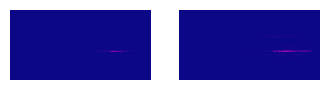

epoch:  59%|████████████████████▋              | 59/100 [08:41<05:56,  8.70s/it]


Epoch 059 val_loss 0.0005


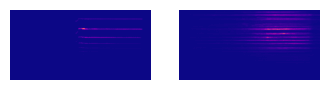

epoch:  60%|█████████████████████              | 60/100 [08:49<05:41,  8.55s/it]


Epoch 060 val_loss 0.0005


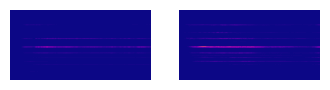

epoch:  61%|█████████████████████▎             | 61/100 [08:57<05:28,  8.41s/it]


Epoch 061 val_loss 0.0005


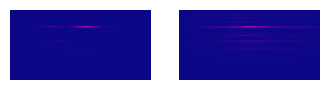

epoch:  62%|█████████████████████▋             | 62/100 [09:05<05:14,  8.28s/it]


Epoch 062 val_loss 0.0005


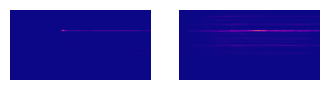

epoch:  63%|██████████████████████             | 63/100 [09:13<05:02,  8.17s/it]


Epoch 063 val_loss 0.0005


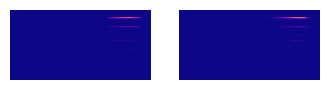

epoch:  64%|██████████████████████▍            | 64/100 [09:21<04:49,  8.05s/it]


Epoch 064 val_loss 0.0005


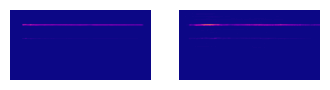

epoch:  65%|██████████████████████▊            | 65/100 [09:29<04:40,  8.02s/it]


Epoch 065 val_loss 0.0005


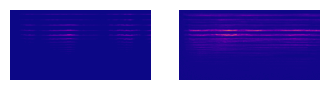

epoch:  66%|███████████████████████            | 66/100 [09:37<04:35,  8.11s/it]


Epoch 066 val_loss 0.0005


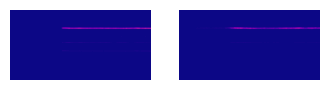

epoch:  67%|███████████████████████▍           | 67/100 [09:45<04:27,  8.09s/it]


Epoch 067 val_loss 0.0005


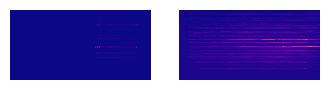

epoch:  68%|███████████████████████▊           | 68/100 [09:55<04:29,  8.43s/it]


Epoch 068 val_loss 0.0005


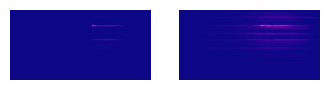

epoch:  69%|████████████████████████▏          | 69/100 [10:03<04:23,  8.49s/it]


Epoch 069 val_loss 0.0005


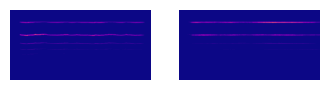

epoch:  70%|████████████████████████▌          | 70/100 [10:11<04:08,  8.30s/it]


Epoch 070 val_loss 0.0005


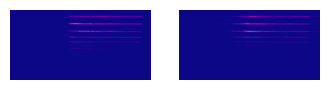

epoch:  71%|████████████████████████▊          | 71/100 [10:19<03:56,  8.17s/it]


Epoch 071 val_loss 0.0005


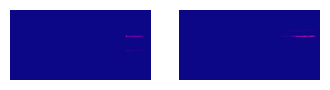

epoch:  72%|█████████████████████████▏         | 72/100 [10:27<03:45,  8.05s/it]


Epoch 072 val_loss 0.0005


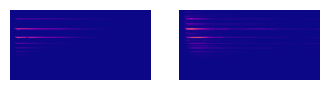

epoch:  73%|█████████████████████████▌         | 73/100 [10:34<03:34,  7.96s/it]


Epoch 073 val_loss 0.0005


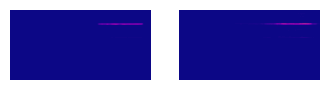

epoch:  74%|█████████████████████████▉         | 74/100 [10:42<03:24,  7.88s/it]


Epoch 074 val_loss 0.0005


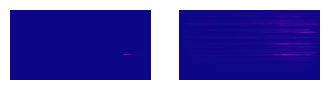

epoch:  75%|██████████████████████████▎        | 75/100 [10:50<03:17,  7.89s/it]


Epoch 075 val_loss 0.0005


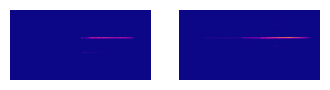

epoch:  76%|██████████████████████████▌        | 76/100 [10:59<03:17,  8.25s/it]


Epoch 076 val_loss 0.0005


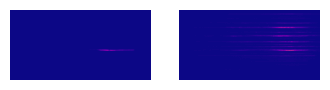

epoch:  77%|██████████████████████████▉        | 77/100 [11:08<03:12,  8.36s/it]


Epoch 077 val_loss 0.0005


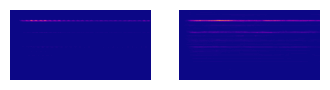

epoch:  78%|███████████████████████████▎       | 78/100 [11:16<03:03,  8.35s/it]


Epoch 078 val_loss 0.0005


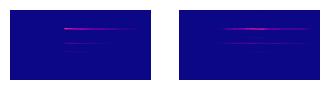

epoch:  79%|███████████████████████████▋       | 79/100 [11:24<02:52,  8.21s/it]


Epoch 079 val_loss 0.0005


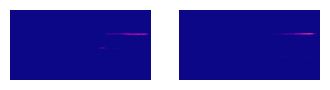

epoch:  80%|████████████████████████████       | 80/100 [11:32<02:44,  8.20s/it]


Epoch 080 val_loss 0.0005


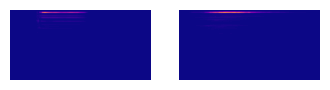

epoch:  81%|████████████████████████████▎      | 81/100 [11:41<02:40,  8.47s/it]


Epoch 081 val_loss 0.0004


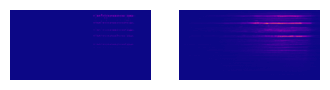

epoch:  82%|████████████████████████████▋      | 82/100 [11:50<02:32,  8.47s/it]


Epoch 082 val_loss 0.0005


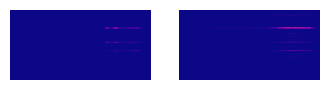

epoch:  83%|█████████████████████████████      | 83/100 [11:58<02:21,  8.34s/it]


Epoch 083 val_loss 0.0005


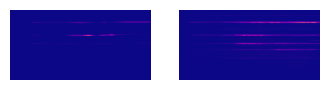

epoch:  84%|█████████████████████████████▍     | 84/100 [12:06<02:11,  8.19s/it]


Epoch 084 val_loss 0.0005


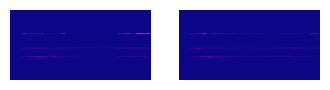

epoch:  85%|█████████████████████████████▊     | 85/100 [12:13<02:01,  8.07s/it]


Epoch 085 val_loss 0.0005


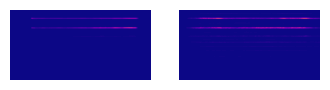

epoch:  86%|██████████████████████████████     | 86/100 [12:21<01:52,  8.02s/it]


Epoch 086 val_loss 0.0005


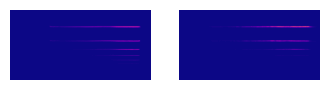

epoch:  87%|██████████████████████████████▍    | 87/100 [12:29<01:43,  7.98s/it]


Epoch 087 val_loss 0.0005


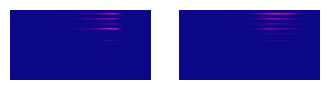

epoch:  88%|██████████████████████████████▊    | 88/100 [12:37<01:36,  8.02s/it]


Epoch 088 val_loss 0.0004


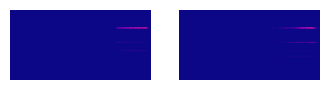

epoch:  89%|███████████████████████████████▏   | 89/100 [12:45<01:27,  7.99s/it]


Epoch 089 val_loss 0.0005


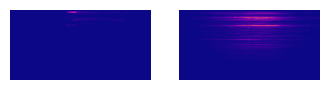

epoch:  90%|███████████████████████████████▌   | 90/100 [12:53<01:20,  8.04s/it]


Epoch 090 val_loss 0.0005


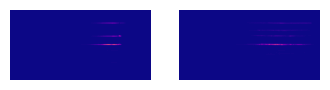

epoch:  91%|███████████████████████████████▊   | 91/100 [13:01<01:12,  8.06s/it]


Epoch 091 val_loss 0.0005


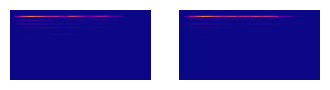

epoch:  92%|████████████████████████████████▏  | 92/100 [13:09<01:04,  8.01s/it]


Epoch 092 val_loss 0.0005


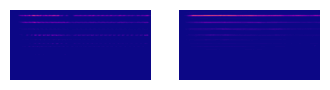

epoch:  93%|████████████████████████████████▌  | 93/100 [13:17<00:55,  7.96s/it]


Epoch 093 val_loss 0.0005


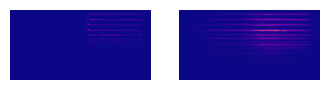

epoch:  94%|████████████████████████████████▉  | 94/100 [13:25<00:48,  8.03s/it]


Epoch 094 val_loss 0.0005


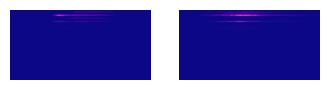

epoch:  95%|█████████████████████████████████▎ | 95/100 [13:35<00:42,  8.43s/it]


Epoch 095 val_loss 0.0004


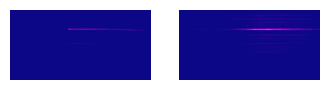

epoch:  96%|█████████████████████████████████▌ | 96/100 [13:43<00:33,  8.38s/it]


Epoch 096 val_loss 0.0004


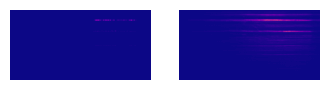

epoch:  97%|█████████████████████████████████▉ | 97/100 [13:52<00:26,  8.68s/it]


Epoch 097 val_loss 0.0005


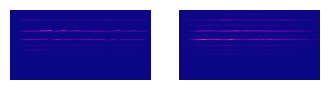

epoch:  98%|██████████████████████████████████▎| 98/100 [14:02<00:17,  8.92s/it]


Epoch 098 val_loss 0.0004


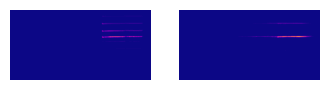

epoch:  99%|██████████████████████████████████▋| 99/100 [14:12<00:09,  9.14s/it]


Epoch 099 val_loss 0.0005


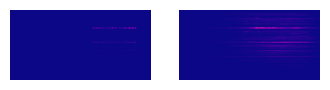

epoch: 100%|██████████████████████████████████| 100/100 [14:21<00:00,  8.62s/it]


Epoch 100 val_loss 0.0004


In [80]:
def vae_loss_fn(x, recon_x, mu, logvar):
    #reconstruction_loss = F.mse_loss(recon_x, x, reduction='sum')
    reconstruction_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + KLD

def evaluate(losses, autoencoder, dataloader, flatten=True):
    model = lambda x, y: autoencoder(x, y)[0]    
    loss_sum = []
    inp, out = [],[]
    loss_fn = nn.MSELoss()
    for inputs, labels in dataloader:
        inputs = inputs.to(DEVICE)
        labels = one_hot(labels,7).to(DEVICE)

        if flatten:
            inputs = inputs.view(inputs.size(0), input_size)

        outputs = model(inputs, labels)
        loss = loss_fn(inputs, outputs)            
        loss_sum.append(loss)
        inp = inputs
        out = outputs

    with torch.set_grad_enabled(False):
        plot_gallery([inp[0].detach().cpu(),out[0].detach().cpu()],256,512,1,2)    

    losses.append((sum(loss_sum)/len(loss_sum)).item())
    
history = train_cvae(cvae, train_dataset, val_dataset)

#name = f"ALL_modello_cvae_{hidden_size}hs_{num_epochs}e_ NO_labels"
#torch.save(cvae, f'{name}.pt')


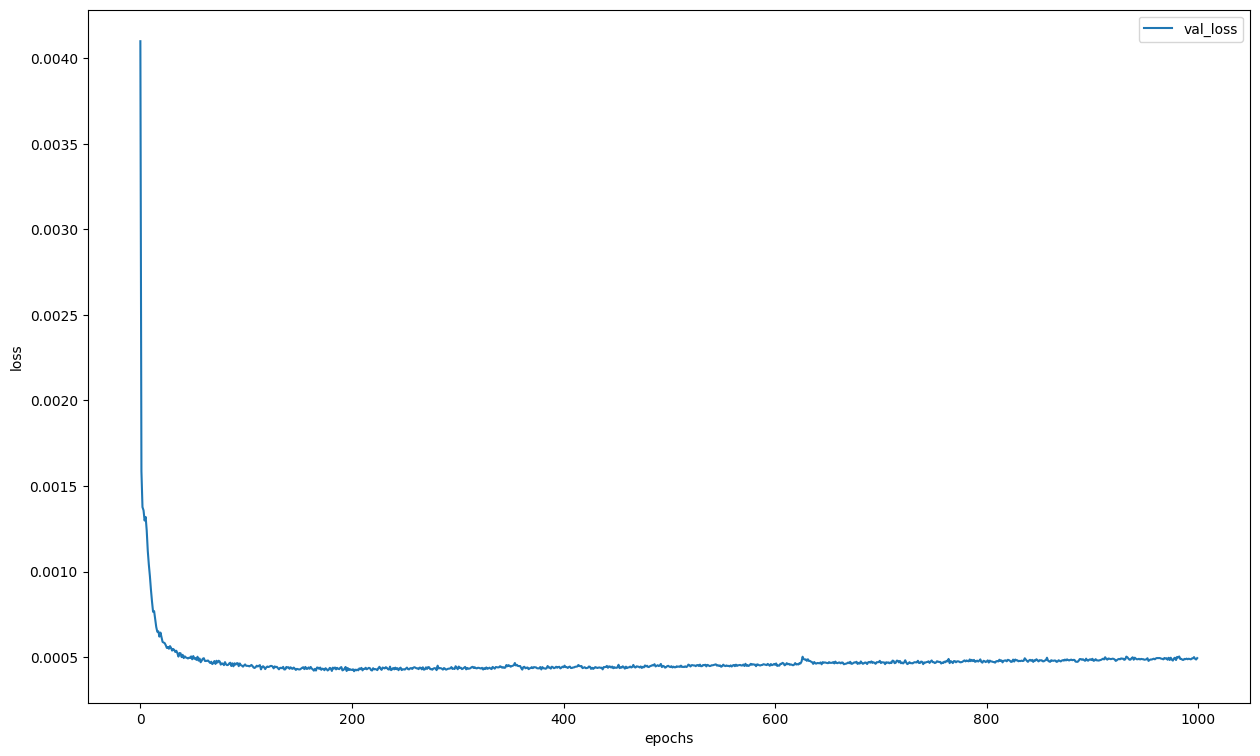

In [441]:
import warnings
warnings.filterwarnings("ignore")

val_loss = history
plt.figure(figsize=(15, 9))
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## PCA & TSNE - Latent Space with Dimensionality Reduction

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


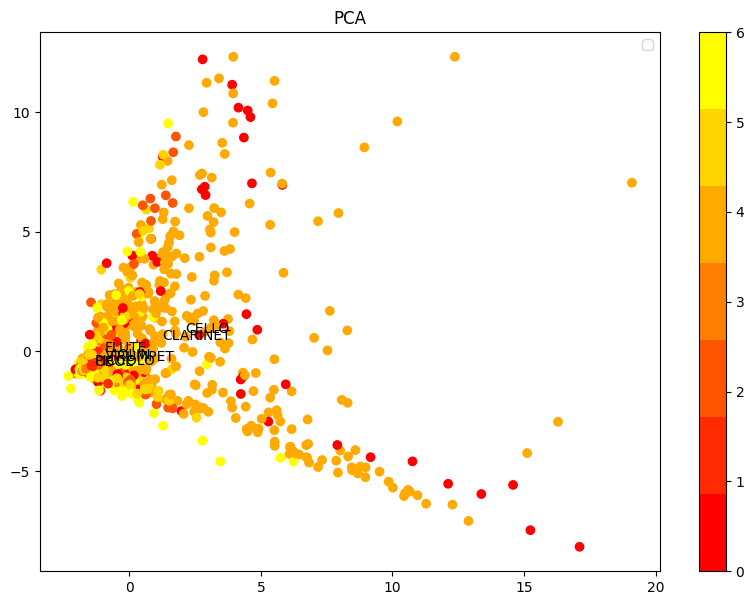

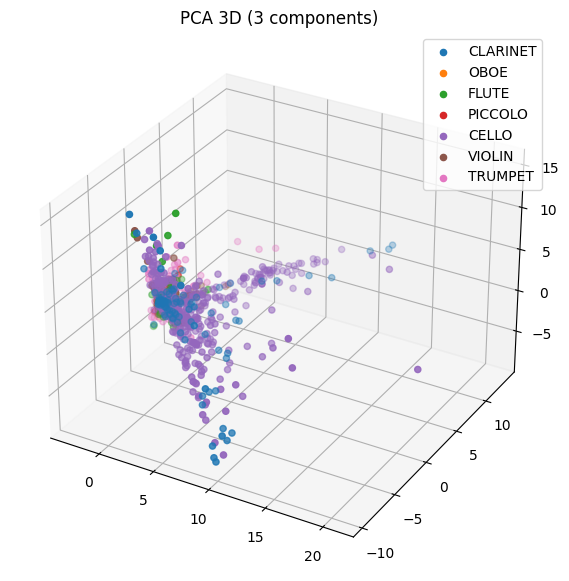

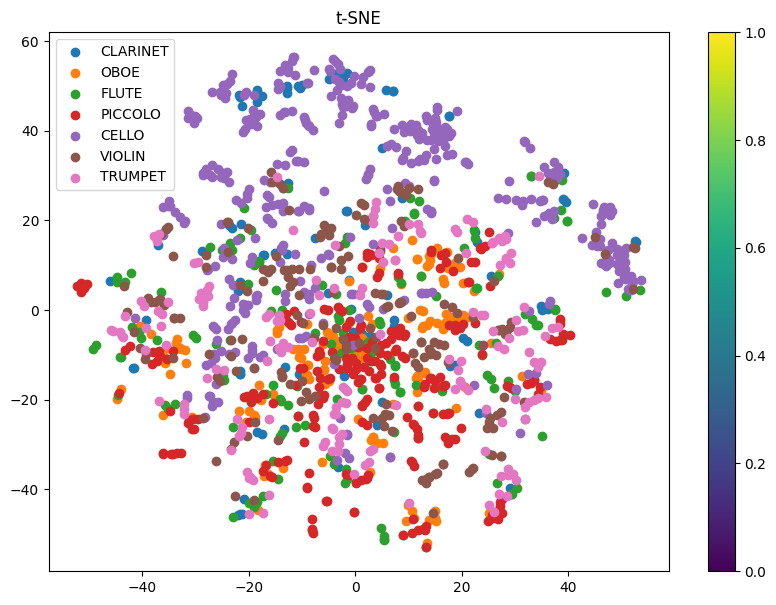

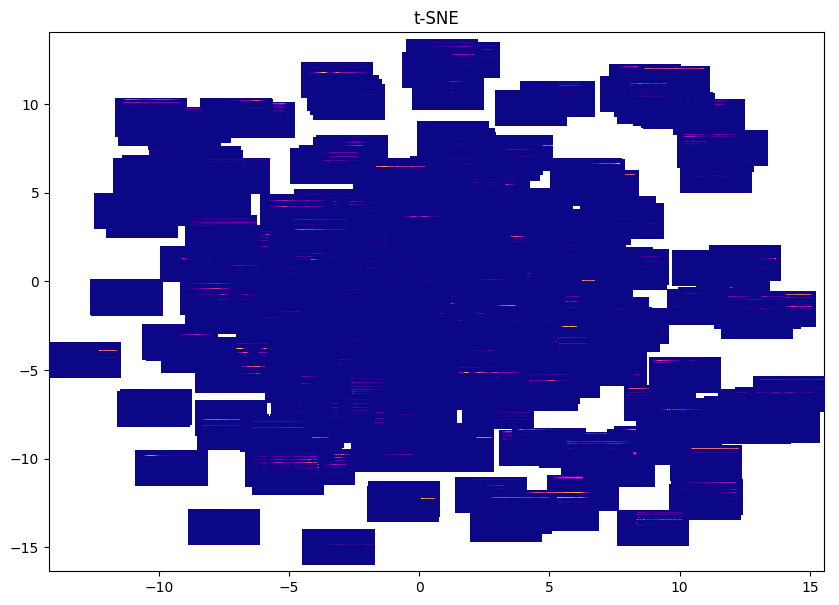

In [442]:
import warnings
warnings.filterwarnings("ignore")

plot_pca(cvae, 'dots', count = 2000, is_cvae = True)
plot_pca_3d(cvae, count = 2000, is_cvae = True)
plot_tsne(net=cvae, mode='dots', count=2000, is_cvae=True)
plot_tsne(net=cvae, mode='imgs', count=300, is_cvae=True)

## SOUND GENERATION

In [1229]:
audio_index = 705

instrument = inv_instrument.get(np.int0(y_train_tensor[audio_index]))
print("This is the sound of a", instrument)

This is the sound of a VIOLIN


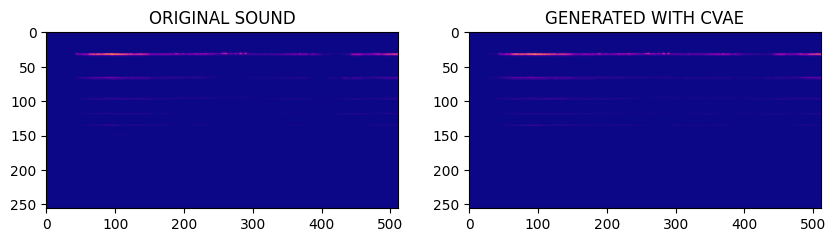

In [1230]:
#ORIGINAL

ori = x_train_tensor[audio_index].view(256, 512).detach().numpy()

#GENERATED

train_labels = one_hot(y_train_tensor, 7)
cvae_latent_space, _ = cvae.encode(x_train_tensor, train_labels)
cvae_generation = cvae.decode(cvae_latent_space)#, train_labels)
cvae_gen_array = cvae_generation[audio_index].view(256, 512).detach().numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(ori, cmap="plasma")
plt.title("ORIGINAL SOUND")

plt.subplot(1, 2, 2)
plt.imshow(cvae_gen_array, cmap="plasma")
plt.title("GENERATED WITH CVAE")

plt.show()

In [707]:
#ORIGINAL

ori = x_train_tensor[audio_index].view(256, 512).detach().numpy()

#GENERATED

train_labels = one_hot(y_train_tensor, 7)
cvae_latent_space, _ = cvae.encode(x_train_tensor, train_labels)
cvae_generation = cvae.decode(cvae_latent_space)#, train_labels)
cvae_gen_array = cvae_generation[audio_index].view(256, 512).detach().numpy()

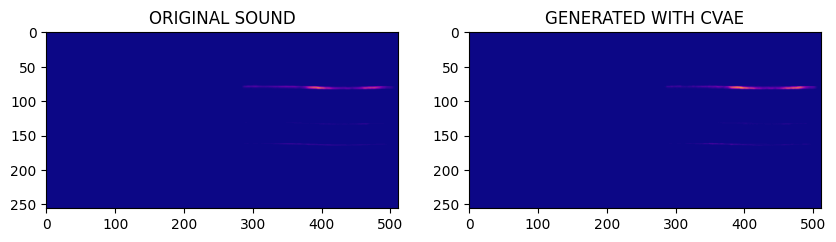

In [708]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(ori, cmap="plasma")
plt.title("ORIGINAL SOUND")

plt.subplot(1, 2, 2)
plt.imshow(cvae_gen_array, cmap="plasma")
plt.title("GENERATED WITH CVAE")

plt.show()

In [709]:
original = x_train_tensor[audio_index].view(256, 512).detach().numpy()
cvae_gen_array = cvae_generation[audio_index].view(256, 512).detach().numpy()

In [710]:
original_audio = librosa.feature.inverse.mel_to_audio(original, n_fft=1024, hop_length=256)
cvae_reconstructed_audio = librosa.feature.inverse.mel_to_audio(cvae_gen_array, n_fft=1024, hop_length=256)

In [711]:
sd.play(original_audio, sr)
sd.wait()

In [712]:
sd.play(cvae_reconstructed_audio, sr)
sd.wait()

In [713]:
#sf.write(f"/Users/chiaradeluca/Desktop/file/harmonic/[O]_{name}_sound{np.int0(y_train_tensor[audio_index])-1}_{audio_index}.wav", original_audio, samplerate=sr)
#sf.write(f"/Users/chiaradeluca/Desktop/file/harmonic/[CVAE]_{name}_sound{np.int0(y_train_tensor[audio_index])-1}_{audio_index}.wav", cvae_reconstructed_audio, samplerate=sr)


## Noise Injection

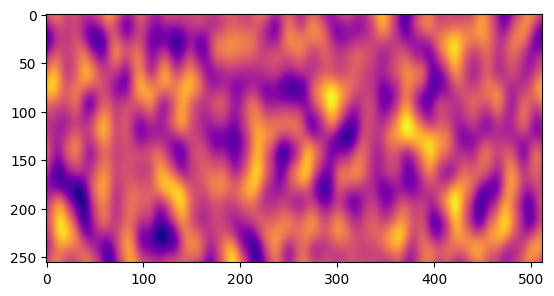

In [54]:
from perlin_noise import PerlinNoise

noise = PerlinNoise(octaves=10, seed=1)
xpix, ypix = 512, 256
pic = [[noise([i/xpix, j/ypix]) for j in range(xpix)] for i in range(ypix)]

pp = np.array(pic)

plt.imshow(pp, cmap='plasma')
plt.show()



In [471]:
noisy_perlin_audio = librosa.feature.inverse.mel_to_audio(cvae_perlin_gen_array, n_fft=1024, hop_length=256)

sd.play(noisy_perlin_audio, sr)
sd.wait()

### Standard noise

In [472]:
noise_std = 0.4
noise = torch.randn_like(cvae_latent_space) * noise_std
noisy_latent_space = cvae_latent_space + noise

Text(0.5, 1.0, 'TRUMPET GENERATED with CVAE ( + noise)')

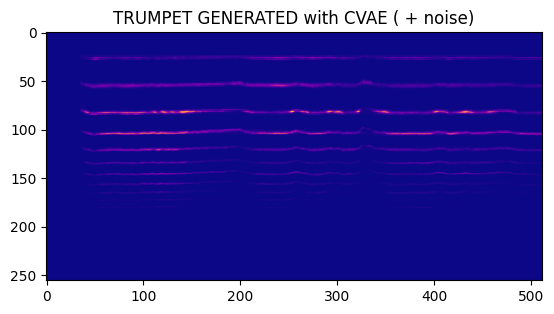

In [473]:
cvae_noisy_generation = cvae.decode(noisy_latent_space, train_labels)
cvae_noisy_gen_array = cvae_noisy_generation[audio_index].view(256, 512).detach().numpy()
plt.imshow(cvae_noisy_gen_array, cmap = "plasma")
plt.title(f"{instrument} GENERATED with CVAE ( + standard noise)")

In [474]:
noisy_cvae_audio = librosa.feature.inverse.mel_to_audio(cvae_noisy_gen_array, n_fft=1024, hop_length=256)

sd.play(noisy_cvae_audio, sr)
sd.wait()
#sf.write(f"/Users/chiaradeluca/Desktop/file/harmonic/[NOISE CVAE]_{name}_sound{np.int0(y_train_tensor[audio_index])-1}_{noise_std}.wav", noisy_cvae_audio, samplerate=sr)


Text(0.5, 1.0, 'Difference between noise and perlin')

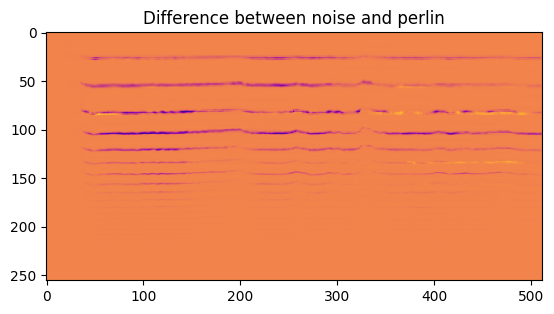

In [475]:
plt.imshow(cvae_perlin_gen_array-cvae_noisy_gen_array, cmap = "plasma")
plt.title("Difference between perlin noise and standard noise")

Text(0.5, 1.0, 'TRUMPET ORIGINAL')

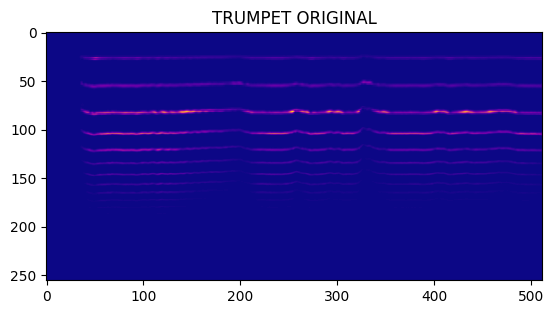

In [476]:
ori_array = x_train_tensor[audio_index].view(256, 512).detach().numpy()
plt.imshow(ori_array, cmap = "plasma")
plt.title(f"{instrument} ORIGINAL")

Text(0.5, 1.0, 'Difference between original and perlin')

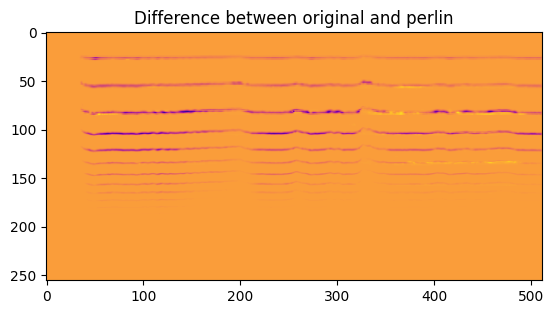

In [477]:
plt.imshow(cvae_perlin_gen_array-ori_array, cmap = "plasma")
plt.title("Difference between original sound and perlin noise injected sound")

## How to mix sound classes

In [883]:
clarinet = x_train_tensor[y_train_tensor==0]
oboe = x_train_tensor[y_train_tensor==1]
flute = x_train_tensor[y_train_tensor==2]
piccolo = x_train_tensor[y_train_tensor==3]

y_clarinet = y_train_tensor[y_train_tensor==0]
y_oboe = y_train_tensor[y_train_tensor==1]
y_flute = y_train_tensor[y_train_tensor==2]
y_piccolo = y_train_tensor[y_train_tensor==3]

In [893]:
audio_index1 = 21
audio_index2 = 5

instrument1 = inv_instrument.get(np.int0(y_train_tensor[audio_index1]))
print("Sound 1 is a", instrument1)
instrument2 = inv_instrument.get(np.int0(y_train_tensor[audio_index2]))
print("Sound 2 is a", instrument2)

Sound 1 is a CELLO
Sound 2 is a TRUMPET


In [894]:
sound1 = x_train_tensor[y_train_tensor==instrument_dict.get(instrument1)]
sound2 = x_train_tensor[y_train_tensor==instrument_dict.get(instrument2)]

y_sound1 = y_train_tensor[y_train_tensor==instrument_dict.get(instrument1)]
y_sound2 = y_train_tensor[y_train_tensor==instrument_dict.get(instrument2)]

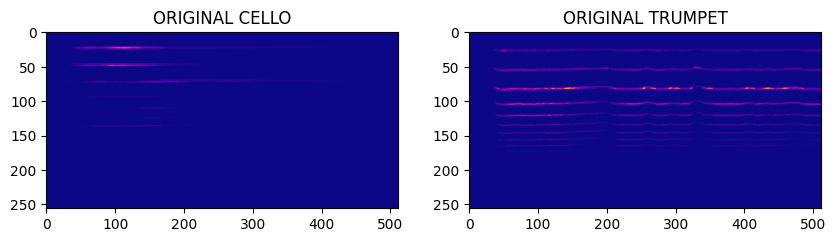

In [895]:
ori1 = sound1[0].view(256, 512).detach().numpy()
ori2 = sound2[0].view(256, 512).detach().numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(ori1, cmap="plasma")
plt.title(f"ORIGINAL {instrument1}")

plt.subplot(1, 2, 2)
plt.imshow(ori2, cmap="plasma")
plt.title(f"ORIGINAL {instrument2}")

plt.show()

In [792]:
lat1 = cvae.encode(sound1[:100], one_hot(y_sound1[:100], max_x = 7))[0]
lat2 = cvae.encode(sound2[:100], one_hot(y_sound2[:100], max_x = 7))[0]

latent_mean = (lat1 + lat2) / 2
mixed_spectrogram = cvae.decode(latent_mean)#, one_hot(y_sound1[:100], max_x = 7))

Text(0.5, 1.0, ' Sound OBOE + Sound PICCOLO')

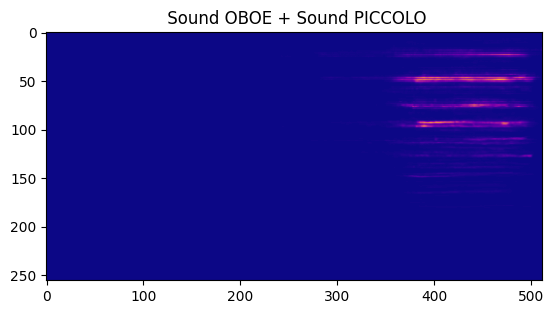

In [793]:
mixed_spectrogram_array = mixed_spectrogram[0].view(256, 512).detach().numpy()
plt.imshow(np.squeeze(mixed_spectrogram_array), cmap = "plasma")
plt.title(f" Sound {instrument1} + Sound {instrument2}")

Text(0.5, 1.0, ' Sound OBOE + Sound PICCOLO')

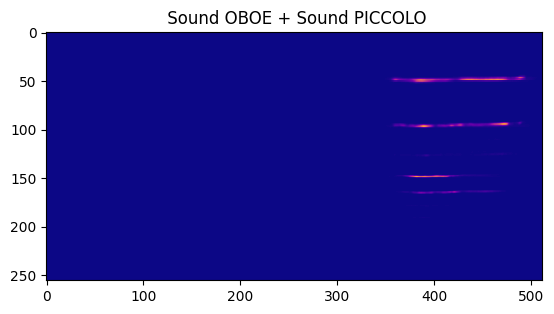

In [794]:
weight_array1 = 0
weight_array2 = 1

weighted_ls = (lat1 * weight_array1 + lat2 * weight_array2) / (weight_array1 + weight_array2)

weighted_spectrogram = cvae.decode(weighted_ls)#, one_hot(y_sound2[:100], max_x = 7))
weighted_spectrogram_array = weighted_spectrogram[0].view(256, 512).detach().numpy()

plt.imshow(weighted_spectrogram_array, cmap = "plasma")
plt.title(f" Sound {instrument1} + Sound {instrument2}")

## How to mix two sounds

This is the preliminary operation for creating sound morphing. Given the latent space, two points are selected (corresponding to two different musical timbres), and, through weighted averaging, a latent space is created that generates sounds incorporating characteristics of the two chosen sounds, according to the weighted average parameters. In the following example, a latent space is created exactly halfway between the two selected points

Text(0.5, 1.0, ' Sound CELLO (0.5) + Sound TRUMPET (0.5)')

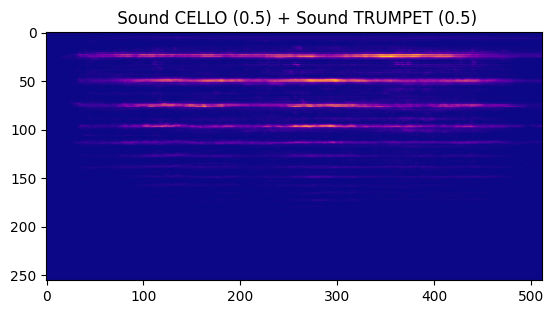

In [899]:
h1 = 6
h2 = 3

lat1 = cvae.encode(sound1[h1], one_hot(y_sound1[22:23], max_x = 7))[0]
lat2 = cvae.encode(sound2[h2], one_hot(y_sound2[:1], max_x = 7))[0]

weight_array1 = 0.5
weight_array2 = 0.5
weighted_ls = (lat1 * weight_array1 + lat2 * weight_array2) / (weight_array1 + weight_array2)

weighted_spectrogram = cvae.decode(weighted_ls)#, one_hot(y_sound2[:1], max_x = 7))
weighted_spectrogram_array = weighted_spectrogram[0].view(256, 512).detach().numpy()

plt.imshow(weighted_spectrogram_array, cmap = "plasma")
plt.title(f" Sound {instrument1} ({weight_array1}) + Sound {instrument2} ({weight_array2})")

In [900]:
weighted = librosa.feature.inverse.mel_to_audio(weighted_spectrogram_array, n_fft=1024, hop_length=256)#, hop_length=96)#  n_fft=726, hop_length=256)#2048)

sd.play(weighted, sr)
sd.wait()

In [812]:
#sf.write(f"/Users/chiaradeluca/Desktop/file/harmonic/[MIXED]_{instrument1}_{weight_array1}lat1+_{instrument2}_{name}_{audio_index1}_{audio_index2}.wav", weighted, samplerate=sr)


## SOUND MORPHING

This section is the heart of sound exploration using VAE. It is indeed possible to transition from one timbre to another in a gradual and smooth manner. This can be achieved through the control of certain parameters (for example, the sounds to be transformed, the number of steps...) and the implementation of crossfading techniques (as previously explained) to make the transformation smooth.

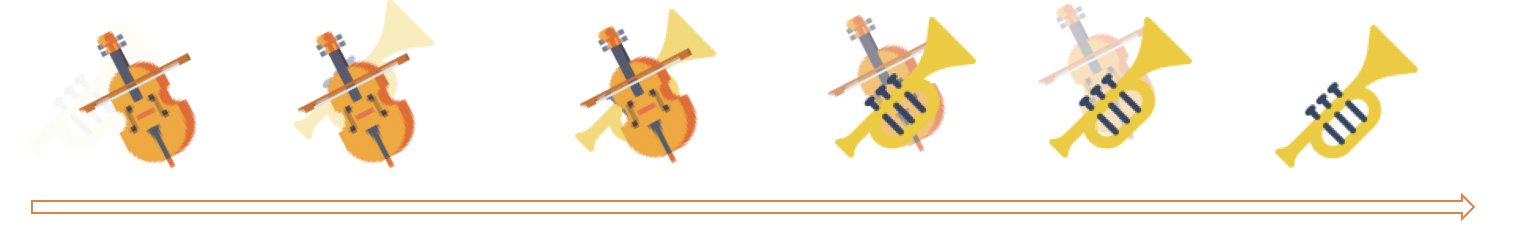

In [35]:
inv_instrument

{0: 'CLARINET',
 1: 'OBOE',
 2: 'FLUTE',
 3: 'PICCOLO',
 4: 'CELLO',
 5: 'VIOLIN',
 6: 'TRUMPET'}

In [39]:
y_train_tensor[:10]

tensor([4, 4, 5, 1, 1, 6, 2, 4, 6, 3])

Sound 1 is a TRUMPET
Sound 2 is a CELLO


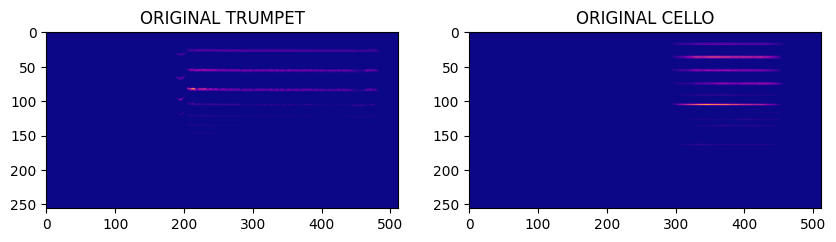

In [40]:
audio_index1 = 5
audio_index2 = 7

h1 = 2
h2 = 3

instrument1 = inv_instrument.get(np.int0(y_train_tensor[audio_index1]))
print("Sound 1 is a", instrument1)
instrument2 = inv_instrument.get(np.int0(y_train_tensor[audio_index2]))
print("Sound 2 is a", instrument2)


sound1 = x_train_tensor[y_train_tensor==instrument_dict.get(instrument1)]
sound2 = x_train_tensor[y_train_tensor==instrument_dict.get(instrument2)] * 3

y_sound1 = y_train_tensor[y_train_tensor==instrument_dict.get(instrument1)]
y_sound2 = y_train_tensor[y_train_tensor==instrument_dict.get(instrument2)]

ori1 = sound1[h1].view(256, 512).detach().numpy()
ori2 = sound2[h2].view(256, 512).detach().numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(ori1, cmap="plasma")
plt.title(f"ORIGINAL {instrument1}")

plt.subplot(1, 2, 2)
plt.imshow(ori2, cmap="plasma")
plt.title(f"ORIGINAL {instrument2}")

plt.show()

In [42]:
suono1 = librosa.feature.inverse.mel_to_audio(ori1, n_fft=1024, hop_length=256)
print(f"This is a {instrument1} SOUND")
sd.play(suono1, sr)
sd.wait()

This is a TRUMPET SOUND


In [43]:
suono2 = librosa.feature.inverse.mel_to_audio(ori2, n_fft=1024, hop_length=256)

print(f"This is a {instrument2} SOUND")
sd.play(suono2, sr)
sd.wait()

This is a CELLO SOUND


Text(0.5, 1.0, ' Sound TRUMPET (0.5) + Sound CELLO (0.5)')

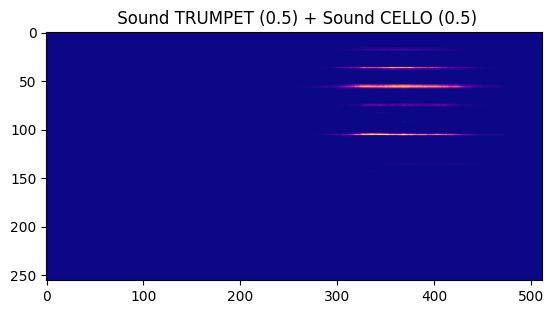

In [44]:
lat1 = cvae.encode(sound1[h1], one_hot(y_sound1[22:23], max_x = 7))[0]
lat2 = cvae.encode(sound2[h2], one_hot(y_sound2[:1], max_x = 7))[0]

weight_array1 = 0.5
weight_array2 = 0.5
weighted_ls = (lat1 * weight_array1 + lat2 * weight_array2) / (weight_array1 + weight_array2)

weighted_spectrogram = cvae.decode(weighted_ls)#, one_hot(y_sound2[:1], max_x = 7))
weighted_spectrogram_array = weighted_spectrogram[0].view(256, 512).detach().numpy()

plt.imshow(weighted_spectrogram_array, cmap = "plasma")
plt.title(f" Sound {instrument1} ({weight_array1}) + Sound {instrument2} ({weight_array2})")

In [45]:
lat1 = cvae.encode(sound1[h1], one_hot(y_sound1[22:23], max_x = 7))[0]
lat2 = cvae.encode(sound2[h2], one_hot(y_sound2[:1], max_x = 7))[0]

weight_array1 = [0, 0.25, 0.5, 0.75, 1]
weight_array2 = [1, 0.75, 0.5, 0.25, 0]
weighted_ls = []
weighted_spectrogram = []
weighted_spectrogram_array = []
sound_audios = []

for i in range(len(weight_array1)):
    tt = (lat1 * weight_array1[i] + lat2 * weight_array2[i]) / (weight_array1[i] + weight_array2[i])
    weighted_ls.append(tt)
    weighted_spectrogram.append(cvae.decode(weighted_ls[i]))
    weighted_spectrogram_array.append(weighted_spectrogram[i].view(256, 512).detach().numpy())
    sound_audios.append(librosa.feature.inverse.mel_to_audio(np.squeeze(weighted_spectrogram_array[i]), hop_length=256, n_fft=1024))#1024)#2048))

    
    

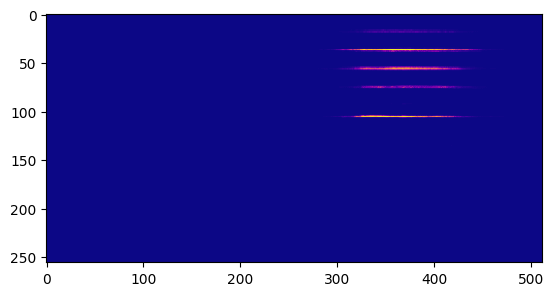

In [46]:
plt.imshow(weighted_spectrogram_array[1], cmap = "plasma")

In [47]:
sd.play(sound_audios[3], sr)

### Final sound morphing

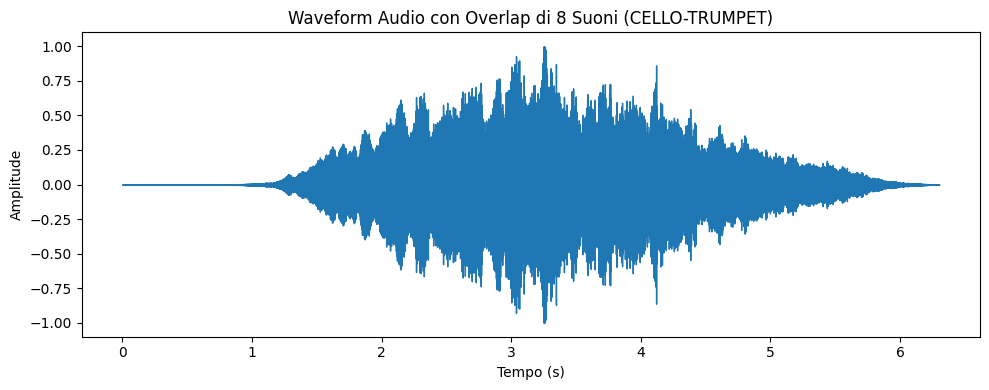

In [48]:
def overlap_sounds(sounds, sr, sec):
    
    overlap_samples = 75000
    result = sounds[0]
    
    for i in range(1, len(sounds)):
        overlap1 = result[-overlap_samples:]
        overlap2 = sounds[i][:overlap_samples]
        average_overlap = (overlap1 + overlap2) #* 1.2
        result = np.concatenate((result[:-overlap_samples], average_overlap, sounds[i][overlap_samples:]))

    return result


lat1 = cvae.encode(sound1[h1], one_hot(y_sound1[22:23], max_x = 7))[0]
lat2 = cvae.encode(sound2[h2], one_hot(y_sound2[:1], max_x = 7))[0]

weight_array1 = np.arange(0, 1.1, 0.2)
weight_array2 = np.arange(1, -0.1, -0.2)
weighted_ls = []
weighted_spectrogram = []
weighted_spectrogram_array = []
sound_audios = []

for i in range(len(weight_array1)):
    tt = (lat1 * weight_array1[i] + lat2 * weight_array2[i]) / (weight_array1[i] + weight_array2[i])
    weighted_ls.append(tt)
    weighted_spectrogram.append(cvae.decode(weighted_ls[i]))#, one_hot(y_sound2[:1], max_x = 7)))
    weighted_spectrogram_array.append(weighted_spectrogram[i].view(256, 512).detach().numpy())
    weighted_spectrogram_array[i] = weighted_spectrogram_array[i]#+pp*0.00001
    sound_audios.append(librosa.feature.inverse.mel_to_audio(np.squeeze(weighted_spectrogram_array[i]), hop_length=256, n_fft=1024))#1024)#2048))

sec = 2
fade_duration_samples = 70000

suono_faded1 = []
suono_faded2 = []

for i in range(len(weight_array1)):
    suono_faded1.append(apply_log_fadeout(sound_audios[i][50000:], fade_duration_samples))
    suono_faded2.append(apply_log_fadein(suono_faded1[i], fade_duration_samples))


sounds = [suono_faded2[0]] * 3 + [suono_faded2[i] for i in range(1, len(weight_array1 - 1))] + [suono_faded2[-1]] * 3

#sounds = [suono_faded2[0][:70000], suono_faded2[1][10000:80000], suono_faded2[2][20000:90000], suono_faded2[3][:90000], suono_faded2[4], suono_faded2[5], suono_faded2[6], suono_faded2[7], suono_faded2[8], suono_faded2[8], suono_faded2[9], suono_faded2[9],suono_faded2[9]]


overlapped_sound = overlap_sounds(sounds, sr, sec)

max_abs_value = np.max(np.abs(overlapped_sound))

normalized_array = overlapped_sound / max_abs_value

plt.figure(figsize=(10, 4))
librosa.display.waveshow(normalized_array, sr=sr)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title(f'Waveform Audio con Overlap di {len(sounds)-3} Suoni ({instrument2}-{instrument1})')
plt.tight_layout()
plt.show()

sd.play(normalized_array, sr)
sd.wait()

  

In [1117]:
#sf.write(f"/Users/chiaradeluca/Desktop/file/harmonic/MORPHING_{instrument2}_{instrument1}_{len(sounds)-3}steps_{octaves}perlin.wav", normalized_array, samplerate=sr)

In [52]:
octaves = 100

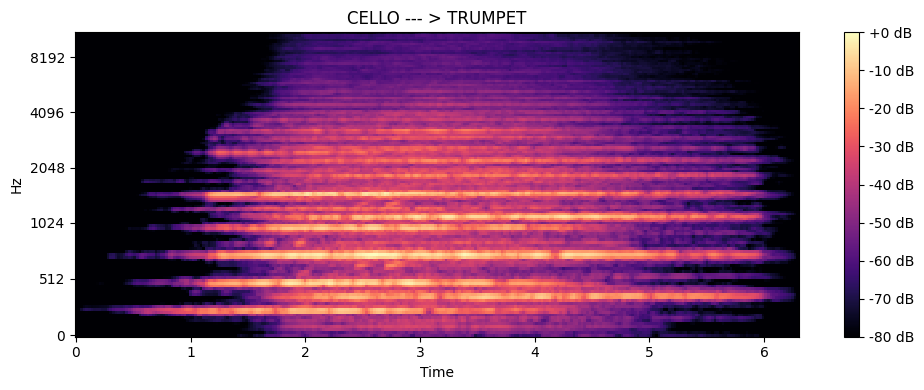

In [53]:
y, sr = librosa.load(f"/Users/chiaradeluca/Desktop/file/harmonic/MORPHING_{instrument2}_{instrument1}_{len(sounds)-3}steps_{octaves}perlin.wav", sr = None)

# Calcola il Mel spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y = y, sr=22050)

# Converte il Mel spectrogram in scala logaritmica
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

# Visualizza il Mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_mel_spectrogram, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title(f"{instrument2} --- > {instrument1}")
plt.tight_layout()
plt.show()

## Appendix - INTERPOLATION

In [207]:
alpha = 0.8
interpolated_ls = alpha * lat1 + (1 - alpha) * lat2

interpolated_spectrogram = cvae.decode(interpolated_ls, train_labels[:1])
interpolated_spectrogram_array = interpolated_spectrogram[0].view(256, 512).detach().numpy()

interpolated = librosa.feature.inverse.mel_to_audio(interpolated_spectrogram_array, hop_length=96)

In [208]:
sd.play(interpolated, sr)
sd.wait()

In [ ]:
#sf.write("/Users/chiaradeluca/Desktop/file/harmonic/[INTERPOLATION]_{instrument1}_{instrument2}_{name}.wav", interpolated, samplerate=sr)
